# Tutorial followed from https://blog.paperspace.com/getting-started-with-openai-gym/

In [1]:
import gym
import matplotlib.pyplot as plt


In [2]:
env = gym.make('MountainCar-v0')

In [3]:
# observation space and action space

obs_space = env.observation_space
action_space = env.action_space
print('The observation space: {}'.format(obs_space)) # velocity and position
# middle point between the two mountains is the origin
print('The action space: {}'.format(action_space))

The observation space: Box(-1.2000000476837158, 0.6000000238418579, (2,), float32)
The action space: Discrete(3)


In [4]:
# reset: resets the env to initial state and returns initial obs
# step: takes action and applies on env, env moves to a new state, returns next state, reward, done, info

In [5]:
obs = env.reset()
print(f'Initial observation: {obs}')

random_action = env.action_space.sample()

new_obs, reward, done, info = env.step(random_action)
print(f'New observation:{new_obs}')

Initial observation: [-0.59431245  0.        ]
New observation:[-5.94786066e-01 -4.73616485e-04]


In [6]:
env.render(mode="human")
env.close()

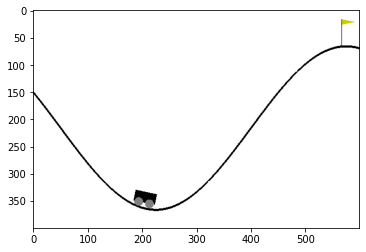

In [7]:
env_screen = env.render(mode='rgb_array')
env.close()
plt.imshow(env_screen)

In [8]:
import time

num_steps = 1500
obs = env.reset()

for step in range(num_steps):
    action = env.action_space.sample()

    obs, reward, done, info = env.step(action)

    env.render()

    time.sleep(0.001)

    if done:
        env.reset()

env.close()

# Spaces

Box and Discrete are types of data structures called "Spaces" provided by Gym

All of these data structures are derived from the gym.Space base class

## Box

In [9]:
type(env.observation_space)

gym.spaces.box.Box

Box corresponds to the n-dim continuous space; here n=2 ie a 2D space

The space is bounded by upper and lower limits which describe the legitimate values obs can take

Can determine this using high and low attributes of obs space; these correspond to the max and min positions/velocities our env can take

In [10]:
print(f'Upper bound for env obs: {env.observation_space.high}')
print(f'Lower bound for env obs: {env.observation_space.low}')

Upper bound for env obs: [0.6  0.07]
Lower bound for env obs: [-1.2  -0.07]


## Discrete

Describes a discrete space with [0,...,n-1] possible values; here n = 3

Meaning our action can take [0,1,2] only

Defines the allowed values strictly

Inputting a non-allowed action value will give an error

In [11]:
env.step(2)
print('Works')

# env.step(4)
# print('Doesn\'t works')

Works


# Wrappers

Wrapper class provides with the functionality to modify various parts of an env

Using Atari Breakout with random actions to showcase this

In [12]:
env = gym.make('BreakoutNoFrameskip-v4')
print(f'Observation Space:{env.observation_space}')
print(f'Action Space: {env.action_space}')

Observation Space:Box(0, 255, (210, 160, 3), uint8)
Action Space: Discrete(4)


In [13]:
obs = env.reset()

for i in range(1000):
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    env.render()
    time.sleep(0.01)
env.close()

Now that we have our environment loaded, let us suppose we have to make certain changes to the Atari Environment. It's a common practice in Deep RL that we construct our observation by concatenating the past k frames together. We have to modify the Breakout Environment such that both our reset and step functions return concatenated observations

In [14]:
from collections import deque
from gym import spaces
import numpy as np      

In [15]:
class concatObs(gym.Wrapper):
    def __init__(self, env, k):
        gym.Wrapper.__init__(self, env)
        self.k = k
        self.frames = deque([], maxlen=k)
        shp = env.observation_space.shape
        self.observation_space = \
            spaces.Box(low=0, high=255, shape=((k,)+shp), dtype=env.observation_space.dtype)

    def reset(self):
        ob = self.env.reset()
        for _ in range(self.k):
            self.frames.append(obs)
        return self._get_ob()
    
    def step(self, action):
        ob, reward, done, info = self.env.step(action)
        self.frames.append(ob)
        return self._get_ob(), reward, done, info

    def _get_ob(self):
        return np.array(self.frames)

Now, to effectively get our modified environment, we wrap our environment Env in the wrapper we just created.

In [16]:
env = gym.make("BreakoutNoFrameskip-v4")
wrapped_env = concatObs(env, 4)
print(f'The new observation space is: {wrapped_env.observation_space}')

The new observation space is: Box(0, 255, (4, 210, 160, 3), uint8)


In [17]:
obs = wrapped_env.reset()
print(f'Initial obs is of the shape: {obs.shape}')

obs, _, _, _ = wrapped_env.step(2)
print(f'Obs after taking a step is: {obs.shape}')

Initial obs is of the shape: (4, 210, 160, 3)
Obs after taking a step is: (4, 210, 160, 3)


There is more to Wrappers than the vanilla Wrapper class. Gym also provides you with specific wrappers that target specific elements of the environment, such as observations, rewards, and actions. Their use is demonstrated in the following section.

1. ObservationWrapper: This helps us make changes to the observation using the observation method of the wrapper class.
2. RewardWrapper: This helps us make changes to the reward using the reward function of the wrapper class.
3. ActionWrapper: This helps us make changes to the action using the action function of the wrapper class.

Let us suppose that we have to make the follow changes to our environment:

1. We have to normalize the pixel observations by 255.
2. We have to clip the rewards between 0 and 1.
3. We have to prevent the slider from moving to the left (action 3).

In [18]:
import random

class ObservationWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
    
    def observation(self, obs):
        # normalize with 255
        return obs/255.0

class RewardWrapper(gym.RewardWrapper):
    def __init__(self, env):
        super().__init__(env)
    
    def reward(self, reward):
        # clip reward bw 0 and 1
        return np.clip(reward,0,1)

class ActionWrapper(gym.ActionWrapper):
    def __init__(self, env):
        super().__init__(env)
    
    def action(self, action):
        if action == 3:
            return random.choice([0,1,2])
        else: 
            return action

In [19]:
env = gym.make('BreakoutNoFrameskip-v4')
wrapped_env = ObservationWrapper(RewardWrapper(ActionWrapper(env)))

obs = wrapped_env.reset()

for step in range(500):
    action = wrapped_env.action_space.sample()
    obs, reward, done, info = wrapped_env.step(action)

    if (obs>1.0).any() or (obs < 0.0).any():
        print('Obs value out of range [0,1]') 

    if reward < 0.0 or reward > 1.0:
        assert False, "Reward out of bounds"

    # check if slider moves left or not
    wrapped_env.render()

    time.sleep(0.001)

wrapped_env.close()

print('All checks passed')

All checks passed


In [20]:
print("Wrapped Env:", wrapped_env)
print("Unwrapped Env", wrapped_env.unwrapped)
print("Getting the meaning of actions", wrapped_env.unwrapped.get_action_meanings())

Wrapped Env: <ObservationWrapper<RewardWrapper<ActionWrapper<TimeLimit<AtariEnv<BreakoutNoFrameskip-v4>>>>>>
Unwrapped Env <AtariEnv<BreakoutNoFrameskip-v4>>
Getting the meaning of actions ['NOOP', 'FIRE', 'RIGHT', 'LEFT']
